<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg" />
    
**<center>[mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course** </center><br>
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel).[mlcourse.ai](https://mlcourse.ai) is powered by [OpenDataScience (ods.ai)](https://ods.ai/) © 2017—2021

# <center>Assignment #3. Optional part. Task </center> <a class="tocSkip">
## <center>Implementation of the decision tree algorithm </center><a class="tocSkip">

If you want to truly understand the algorithm that you are using, it's good to implement it from scratch. Have to say, it's not necessary if you just want to apply an algorithm in practice. However, if you love math, algorithms and programming, you'll enjoy this task.  
<img src='../../_static/img/quote_feynman.jpg' width=50%>

### Your task is to:
 1. write code and perform computations in the cells below;
 2. choose answers in the [webform](https://docs.google.com/forms/d/1SYwUD0Yx_bcykq6EqFQ4Ug0KaQWG4L7bAlL5yGedZnw).
    

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a3_bonus__. If you are sure that something is not 100% correct, please leave your feedback via the mentioned webform ↑*

-----

In [178]:
import numpy as np

# if seaborn is not yet installed, run `pip install seaborn` in terminal
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.datasets import (
    load_boston,
    load_digits,
    make_classification,
    make_regression,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split

sns.set()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# sharper plots
%config InlineBackend.figure_format = 'retina'

Let's fix `random_state` (a.k.a. random seed) beforehand.

In [4]:
RANDOM_STATE = 17

**Implement the class `DecisionTree`**
**Specification:**
- the class is inherited from `sklearn.BaseEstimator`;
- class constructor has the following parameters: 
    - `max_depth` - maximum depth of the tree (`numpy.inf` by default); 
    - `min_samples_split` - the minimum number of instances in a node for a splitting to be done (2 by default); 
    - `criterion` - split criterion ('gini' or 'entropy' for classification, 'variance' or 'mad_median' for regression; 'gini' by default);
- the class has several methods: `fit`, `predict` and `predict_proba`;
- the`fit` method takes the matrix of instances `X` and a target vector `y` (`numpy.ndarray` objects) and returns an instance of the class `DecisionTree` representing the decision tree trained on the dataset `(X, y)` according to parameters set in the constructor; 
- the `predict_proba` method takes the matrix of instances `X` and returns the matrix `P` of a size `X.shape[0] x K`, where `K` is the number of classes and $p_{ij}$ is the probability of an instance in $i$-th row of `X` to belong to class $j \in \{1, \dots, K\}$.
- the `predict` method takes the matrix of instances `X` and returns a prediction vector; in case of classification, prediction for an instance $x_i$ falling into leaf $L$ will be the class, mostly represented among instances in $L$. In case of regression, it'll be the mean value of targets for all instances in leaf $L$.

A note on `criterion`: this is the functional to be maximized to find an optimal partition at a given node has the form $Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$ where $X$ are samples at a given node, $X_l$ and $X_r$ are partitions of samples $X$ into two parts with the following condition $[x_j < t]$, and $F(X)$ is a partition criterion.
    
For classification: let $p_i$ be the fraction of the instances of the $i$-th class in the dataset $X$.
- 'gini': Gini impurity $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
- 'entropy': Entropy $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
For regression: $y_j = y(x_j)$ - is a target for an instance $x_j$, $y = (y_1, \dots, y_{|X|})$ - is a target vector.
- 'variance': Variance (mean quadratic deviation from average) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
- 'mad_median': Mean deviation from the median $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    

In [38]:
# You code here (read-only in a JupyterBook, pls run jupyter-notebook to edit)


def entropy(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return -np.dot(p, np.log2(p))
    


def gini(y):
    p = [len(y[y == k]) / len(y) for k in np.unique(y)]
    return 1 - np.dot(p, p)
    

def variance(y):
    return np.var(y)


def mad_median(y):
    return np.mean(abs(y - np.median(y)))


criteria_dict = {
    'entropy': entropy,
    'gini': gini,
    'variance': variance,
    'mad_median': mad_median
}

The `Node` class implements a node in the decision tree.

In [39]:
class Node:
    def __init__(self, feature_idx=0, threshold=0, labels=None, left=None, right=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.labels = labels
        self.left = left
        self.right = right

Let's determine the function for calculating a prediction in a leaf. For regression, let's take the mean for all values in a leaf, for classification - the most popular class in leaf.

In [211]:
def regression_leaf(y):
    return np.mean(y)


def classification_leaf(y):
    return np.bincount(y).argmax()


In [212]:

class DecisionTree(BaseEstimator):
    def __init__(
        self, max_depth=np.inf, min_samples_split=2, criterion="gini", debug=False,
    ):
        params = {
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'criterion': criterion,
            'debug': debug,
        }
        
        for param_name, param_value in params.items():
            setattr(self, param_name, param_value)
            
        super(DecisionTree, self).set_params(**params)
        
        self._criterian_function = criteria_dict[criterion]
        
        if criterion in ['variance', 'mad_median']:
            self._leaf_value = regression_leaf

        else:
            self._leaf_value = classification_leaf
        if self.debug:
            print(f'\nDecision Tree params:\n{params}')
    
    def _functional(self, X, y, feature_idx, threshold):
        mask = X[:, feature_idx] < threshold
        n_obj = X.shape[0]
        n_left = np.sum(mask)
        n_right = n_obj - n_left
        if n_left > 0 and n_right > 0:
            return (
                self._criterian_function(y)
                - n_left / n_obj * self._criterian_function(y[mask])
                - n_right / n_obj * self._criterian_function(y[~mask])
            )
        else:
            return 0
    
    
    def _build_tree(self, X, y, depth=1):
        max_functional = 0
        best_feature_idx = None
        best_threshold = None
        n_samples, n_features = X.shape
        
        if len(np.unique(y)) == 1:
            return Node(labels=y)
        
        if depth < self.max_depth and n_samples >= self.min_samples_split:
            if self.debug:
                print(f'Depth: {depth}, n_samples: {n_samples}')
            
            for feature_idx in range(n_features):
                threshold_values = np.unique(X[:, feature_idx])
                functional_values = [
                    self._functional(X, y, feature_idx, threshold)
                    for threshold in threshold_values
                ]
                
                best_threshold_idx = np.nanargmax(functional_values)
                
                if functional_values[best_threshold_idx] > max_functional:
                    max_functional = functional_values[best_threshold_idx]
                    best_threshold = threshold_values[best_threshold_idx]
                    best_feature_idx = feature_idx
                    best_mask = X[:, feature_idx] < best_threshold
            
        if best_feature_idx is not None:
            if self.debug:
                print(f'Best feature: {best_feature_idx}. Best threshold: {best_threshold}')

            return Node(
                feature_idx=best_feature_idx,
                threshold=best_threshold,
                left = self._build_tree(X[best_mask, :], y[best_mask], depth + 1),
                right = self._build_tree(X[~best_mask,:], y[~best_mask], depth + 1)
            )
        else:
            return Node(labels=y)
        

    def fit(self, X, y):
        if self.criterion in ['gini', 'entropy']:
            self._n_classes = len(np.unique(y))
        
        self.root = self._build_tree(X, y)
        
        return self
    
    
    def _predict_object(self, x, node=None):
        
        node = self.root
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
            
        return self._leaf_value(node.labels)

    def predict(self, X):
        return np.array([self._predict_object(x) for x in X])
    
    
    def _predict_proba_object(self, x, node=None):
        node = self.root
        while node.labels is None:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        return [
            len(node.labels[node.labels==k]) / len(node.labels)
            for k in range(self._n_classes)
        ]
    

    def predict_proba(self, X):
        return np.array([self._predict_proba_object(x) for x in X])

## Testing the implemented algorithm

### Classification

In [118]:
from sklearn.tree import DecisionTreeClassifier as tr


Decision Tree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'debug': True}
Depth: 1, n_samples: 280
Best feature: 1. Best threshold: -0.045257943644649634
Accuracy: 0.8166666666666667
predict_proba works!


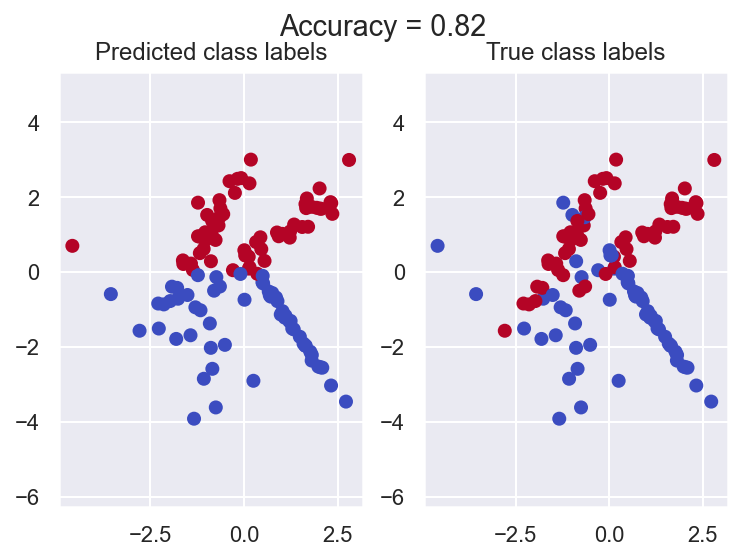

In [119]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_samples=400, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

clf = DecisionTree(max_depth=2, criterion="gini", debug=True)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
prob_pred = clf.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

if sum(np.argmax(prob_pred, axis=1) - y_pred) == 0:
    print("predict_proba works!")

plt.suptitle("Accuracy = {:.2f}".format(accuracy))
plt.subplot(121)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=plt.cm.coolwarm)
plt.title("Predicted class labels")
plt.axis("equal")
plt.subplot(122)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.coolwarm)
plt.title("True class labels")
plt.axis("equal");

Download the dataset `digits` using the method `load_digits`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, and `random_state=17`. Try to train shallow decision trees and make sure that gini and entropy criteria return different results.

In [124]:
digits = load_digits()

X = digits.data
y = digits.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=17)

for criteria in ['gini', 'entropy']:
    clf = DecisionTree(max_depth=2, criterion=criteria, debug=True)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    print(f'\ncritria: {criteria}')
    accuracy = accuracy_score(y_val, pred)
    print(f'accuracy: {accuracy}')


Decision Tree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'gini', 'debug': True}
Depth: 1, n_samples: 1437
Best feature: 36. Best threshold: 1.0

critria: gini
accuracy: 0.18888888888888888

Decision Tree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'entropy', 'debug': True}
Depth: 1, n_samples: 1437
Best feature: 21. Best threshold: 2.0

critria: entropy
accuracy: 0.175


Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use range(3, 11), for criterion use {'gini', 'entropy'}. Quality measure is `scoring`='accuracy'.

In [141]:
%%time
params = {'max_depth': range(3, 15)}

grid1 = GridSearchCV(DecisionTree(criterion='gini'), params, cv=5, scoring='accuracy', n_jobs=4, verbose=3)
grid1.fit(X_train, y_train)
print(grid1.best_score_, grid1.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.8434306039488966 {'max_depth': 10}
CPU times: user 4.97 s, sys: 161 ms, total: 5.13 s
Wall time: 1min 26s


In [142]:
%%time
params = {'max_depth': range(3, 15)}

grid2 = GridSearchCV(DecisionTree(criterion='entropy'), params, cv=5, scoring='accuracy', n_jobs=4)
grid2.fit(X_train, y_train)
print(grid2.best_score_, grid2.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0.8629186024003097 {'max_depth': 9}
CPU times: user 4.33 s, sys: 24.5 ms, total: 4.35 s
Wall time: 1min 26s


Draw the plot of the mean quality measure `accuracy` for criteria `gini` and `entropy` depending on `max_depth`.

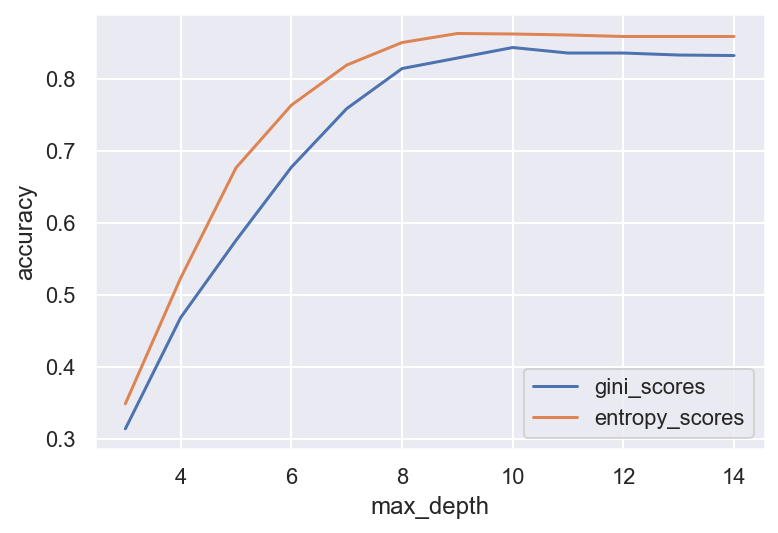

[CV 3/5] END .......................max_depth=3;, score=0.359 total time=   1.0s
[CV 2/5] END .......................max_depth=4;, score=0.493 total time=   1.9s
[CV 2/5] END .......................max_depth=5;, score=0.688 total time=   2.9s
[CV 1/5] END .......................max_depth=6;, score=0.774 total time=   4.8s
[CV 5/5] END .......................max_depth=6;, score=0.742 total time=   4.0s
[CV 4/5] END .......................max_depth=7;, score=0.808 total time=   5.6s
[CV 3/5] END .......................max_depth=8;, score=0.819 total time=   5.8s
[CV 2/5] END .......................max_depth=9;, score=0.868 total time=   8.0s
[CV 1/5] END ......................max_depth=10;, score=0.840 total time=   7.6s
[CV 5/5] END ......................max_depth=10;, score=0.871 total time=   5.4s
[CV 3/5] END .......................max_depth=3;, score=0.317 total time=   1.0s
[CV 3/5] END .......................max_depth=4;, score=0.467 total time=   1.6s
[CV 1/5] END ...............

[CV 1/5] END .......................max_depth=3;, score=0.333 total time=   1.0s
[CV 1/5] END .......................max_depth=4;, score=0.507 total time=   1.8s
[CV 5/5] END .......................max_depth=4;, score=0.519 total time=   1.8s
[CV 4/5] END .......................max_depth=5;, score=0.669 total time=   2.7s
[CV 3/5] END .......................max_depth=6;, score=0.707 total time=   4.5s
[CV 2/5] END .......................max_depth=7;, score=0.847 total time=   5.8s
[CV 1/5] END .......................max_depth=8;, score=0.840 total time=   6.4s
[CV 5/5] END .......................max_depth=8;, score=0.861 total time=   6.8s
[CV 4/5] END .......................max_depth=9;, score=0.902 total time=   7.7s
[CV 3/5] END ......................max_depth=10;, score=0.833 total time=   6.6s
[CV 4/5] END .......................max_depth=3;, score=0.334 total time=   0.9s
[CV 5/5] END .......................max_depth=3;, score=0.296 total time=   0.9s
[CV 4/5] END ...............

In [143]:
gini_scores = grid1.cv_results_['mean_test_score']
entropy_scores = grid2.cv_results_['mean_test_score']
plt.plot(params['max_depth'], gini_scores, label='gini_scores')
plt.plot(params['max_depth'], entropy_scores, label='entropy_scores')
plt.legend(loc='best')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.show()

**<font color='red'>Question 1.</font> Choose all correct statements:**
1. Optimal value of the `max_depth` parameter is on the interval [4, 9] for both criteria.
2. Created plots have no intersection on the interval [3, 10]
3. Created plots intersect each other only once on the interval [3, 10].
4. The best quality for `max_depth` on the interval [3, 10] is reached using `gini` criterion .
5. Accuracy is strictly increasing at least for one of the criteria, when `max_depth` is also increasing on the interval [3, 10]

**<font color='red'>Question 2.</font> What are the optimal values for max_depth and criterion parameters?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy';
6. max_depth = 9, criterion = 'gini';

Train decision tree on `(X_train, y_train)` using the optimal values of `max_depth` and `criterion`. Compute class probabilities for `X_test`.

In [156]:
best_tree = DecisionTree(criterion='entropy', max_depth=9)
best_tree.fit(X_train, y_train)
prob = best_tree.predict_proba(X_val)
prob.shape

(360, 10)

In [159]:
prob[0,:]

array([0.        , 0.91666667, 0.02777778, 0.01388889, 0.        ,
       0.        , 0.        , 0.        , 0.04166667, 0.        ])

Using the given matrix, compute the mean class probabilities for all instances in `X_test`.

In [158]:
mean_probs = np.mean(prob, axis=0)
print(mean_probs, max(mean_probs))

[0.09166667 0.07700282 0.09854938 0.08930086 0.12690476 0.11898148
 0.08194444 0.09805556 0.10465062 0.11294341] 0.12690476190476194


**<font color='red'>Question 3.</font> What is the maximum probability in a resulted vector?**
1. 0.127
2. 0.118
3. 1.0
4. 0.09

## Regression

Mean Squared Error: 165.7607358208333


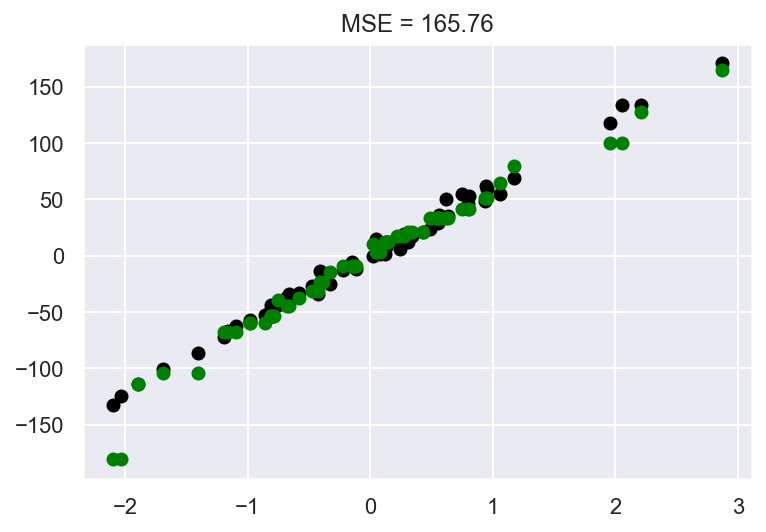

In [213]:
X, y = make_regression(
    n_features=1, n_samples=200, bias=0, noise=5, random_state=RANDOM_STATE
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

reg = DecisionTree(max_depth=6, criterion="mad_median")
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

plt.scatter(X_test[:, 0], y_test, color="black")
plt.scatter(X_test[:, 0], y_pred, color="green")
plt.title("MSE = {:.2f}".format(mse));

Download the dataset `boston` using the method `load_boston`. Split the data into train and test with the `train_test_split` method, use parameter values `test_size=0.2`, `random_state=17`. Try to train shallow regression decision trees and make sure that `variance` and `mad_median` criteria return different results.

In [214]:
boston = load_boston()
train = boston.data
target = boston.target

X_train, X_test, y_train, y_test = train_test_split(train, target, train_size=0.2, random_state=17)

clf1 = DecisionTree(max_depth=2, criterion="variance", debug=True)
clf1.fit(X_train, y_train)

print(mean_squared_error(clf1.predict(X_test), y_test))


clf2 = DecisionTree(max_depth=2, criterion="mad_median", debug=True)
clf2.fit(X_train, y_train)

print(mean_squared_error(clf2.predict(X_test), y_test))


Decision Tree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'variance', 'debug': True}
Depth: 1, n_samples: 101
Best feature: 5. Best threshold: 6.968
50.49245474547292

Decision Tree params:
{'max_depth': 2, 'min_samples_split': 2, 'criterion': 'mad_median', 'debug': True}
Depth: 1, n_samples: 101
Best feature: 5. Best threshold: 6.968
50.49245474547292


Using 5-folds cross-validation (`GridSearchCV`) pick up the optimal values of the `max_depth` and `criterion` parameters. For the parameter `max_depth` use `range(2, 9)`, for `criterion` use {'variance', 'mad_median'}. Quality measure is `scoring`='neg_mean_squared_error'.

In [215]:
%%time
tree_params = {"max_depth": list(range(2, 9))}

grid_reg_crit_mad_median = GridSearchCV(
    estimator=DecisionTree(criterion="mad_median"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=4,
)

grid_reg_crit_mad_median.fit(X_train, y_train)

CPU times: user 782 ms, sys: 13.5 ms, total: 796 ms
Wall time: 8.23 s


GridSearchCV(cv=5, estimator=DecisionTree(criterion='mad_median'), n_jobs=4,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

In [216]:
grid_reg_crit_variance = GridSearchCV(
    estimator=DecisionTree(criterion="variance"),
    param_grid=tree_params,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=4,
)

grid_reg_crit_variance.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTree(criterion='variance'), n_jobs=4,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='neg_mean_squared_error')

Draw the plot of the mean quality measure `neg_mean_squared_error` for criteria `variance` and `mad_median` depending on `max_depth`.

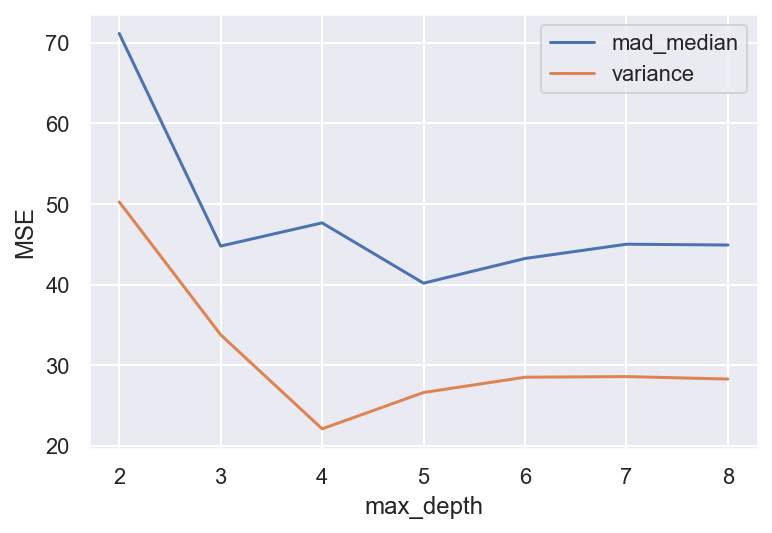

In [217]:
scores_for_crit_mad_median = -np.array(
    grid_reg_crit_mad_median.cv_results_["mean_test_score"]
)
scores_for_crit_variance = -np.array(
    grid_reg_crit_variance.cv_results_["mean_test_score"]
)

plt.plot(tree_params["max_depth"], scores_for_crit_mad_median, label="mad_median")
plt.plot(tree_params["max_depth"], scores_for_crit_variance, label="variance")
plt.legend()
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show();

**<font color='red'>Question 4.</font> Choose all correct statements:**
1. Created plots have no intersection on the interval [2, 8].
2. Created plots intersect each other only once on the interval [2, 8].
3. Optimal value of the `max_depth` for each of the criteria is on the border of the interval [2, 8].
4. The best quality at `max_depth` on the interval [2, 8] is reached using `mad_median` criterion.

**<font color='red'>Question 5.</font> What are the optimal values for `max_depth` and `criterion` parameters?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'.

In [195]:
print("Criterion: mad_median")
print("Best params:", grid_reg_crit_mad_median.best_params_)
print("Best cross validaton MSE:", abs(grid_reg_crit_mad_median.best_score_))

print("Criterion: variance")
print("Best params:", grid_reg_crit_variance.best_params_)
print("Best cross validaton MSE:", abs(grid_reg_crit_variance.best_score_))

Criterion: mad_median
Best params: {'max_depth': 5}
Best cross validaton MSE: 40.167761802604716
Criterion: variance
Best params: {'max_depth': 4}
Best cross validaton MSE: 22.093532050191065
